In [20]:
import Bio
import numpy as np
import sys
import os
import networkx as nx
from tqdm import tqdm # loading bar
from helpers.utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, extend_alignment, Tree, convert_to_desired_format2,convert_format_mat_to_pseudomat,find_min_span_edges,get_visiting_order,new_sp_approxi_combi

from sp_approx_modified import compute_cost, sp_approx
from helpers.utils_copy import nothing,convert_to_desired_format_nr_version



matrix_for_MST=[]

def sp_approxi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring",traversal_here="df"):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    visiting_order,G=get_visiting_order(min_span_edges,str(int(max_row_index)),traversal_here,layout) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    print(visiting_order) #visiting order is now letters, but we would need that as numbers/idices from the score matrix to keep track. #APPARENTLY NOT ACTUALLY IN USE

    # find center string/guide 
    s1_idx = np.argmin(matrix.sum(axis = 1))
    print("nr of seqs:")
    print(len(seqs))
    #seqs_new = [None for _ in range(len(seqs))]
    #s1 = seqs[s1_idx]
    #seqs_new[0]=seqs[s1_idx]
    #for i,element in enumerate(visiting_order,start=1):
     #       seqs_new[i]=seqs[int(element)]
    seqs_new = [None for _ in range(len(seqs))]
    s1 = seqs[s1_idx] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    seqs_new[0] = seqs[int(max_row_index)] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    i=1
    print("new seqs before loop")
    print(seqs_new)
    new_s1_index=None
    for i, idx in enumerate(visiting_order):
        seqs_new[int(idx)] = seqs[i]
        if i==s1_idx:
            new_s1_index=idx
        print("idx:"+str(idx)+", i="+str(i))
    print("new s1-index:")
    print(new_s1_index)
    print("seqs new:")
    print(seqs_new)
    print("old seqs:")
    print(seqs)
    print("matrix for source node inspo:")
    print(matrix)
         
         
    #seqs.insert(0, seqs.pop(s1_idx)) # move guide to front of list
    if verbose: print("The center string, s1, is sequence no." + str(s1_idx+1)) # just a print statement to see which string is the center string

    # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]]
    print("M right now:")
    print(M)
    print("s1 right now:")
    print(s1)
    print("seqs right now")
    print(seqs)
    cost_list = []
    # print("first M = \n" + str(M))
    for i in range(1, len(seqs_new)): #was just seqs bebore
        cost = linear_C(gap_cost, score_matrix, seqs_new[(int(i)-1)], seqs_new[i]) #was just seqs before
        print("\n now aligning...."+str(seqs_new[(int(i)-1)]+ " and "+ str(seqs_new[i])))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs_new[(int(i)-1)], seqs_new[i], cost, score_matrix, gap_cost)
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        A = [list(e) for e in zip(alignment1,alignment2)]
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment(M, A)
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)

    #if return_center_string: return total_cost, M, s1_idx #IDK why this runs for no reason when it's uncommented..
    return total_cost, M, matrix_for_MST, visiting_order,G

[[ 0. 60. 70. 55. 55. 10. 50. 50. 53. 21.]
 [60.  0. 16. 11. 13. 60. 22. 18. 53. 60.]
 [70. 16.  0. 15. 29. 70. 38. 34. 47. 70.]
 [55. 11. 15.  0. 16. 55. 25. 21. 45. 55.]
 [55. 13. 29. 16.  0. 55.  9.  5. 59. 55.]
 [10. 60. 70. 55. 55.  0. 50. 50. 43. 11.]
 [50. 22. 38. 25.  9. 50.  0.  4. 59. 50.]
 [50. 18. 34. 21.  5. 50.  4.  0. 59. 50.]
 [53. 53. 47. 45. 59. 43. 59. 59.  0. 40.]
 [21. 60. 70. 55. 55. 11. 50. 50. 40.  0.]]
this is E (sorted matrix without any stars yet): 
[['' '4' '6' '7']
 ['' '5' '4' '7']
 ['' '9' '4' '6']
 ['' '10' '0' '5']
 ['' '11' '1' '3']
 ['' '11' '5' '9']
 ['' '13' '1' '4']
 ['' '15' '2' '3']
 ['' '16' '1' '2']
 ['' '16' '3' '4']
 ['' '18' '1' '7']
 ['' '21' '0' '9']
 ['' '21' '3' '7']
 ['' '22' '1' '6']
 ['' '25' '3' '6']
 ['' '29' '2' '4']
 ['' '34' '2' '7']
 ['' '38' '2' '6']
 ['' '40' '8' '9']
 ['' '43' '5' '8']
 ['' '45' '3' '8']
 ['' '47' '2' '8']
 ['' '50' '0' '6']
 ['' '50' '0' '7']
 ['' '50' '5' '6']
 ['' '50' '5' '7']
 ['' '50' '6' '9']
 ['' '50'

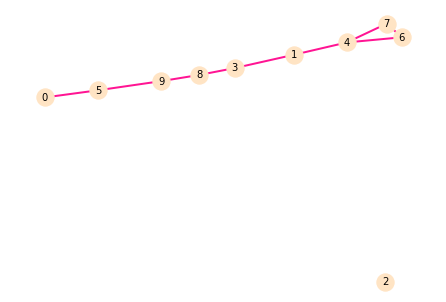

My traversal is df
['0', '5', '9', '8', '3', '1', '4', '7', '6']
nr of seqs:
10
new seqs before loop
['aaaaaaaaa', None, None, None, None, None, None, None, None, None]
idx:0, i=0
idx:5, i=1
idx:9, i=2
idx:8, i=3
idx:3, i=4
idx:1, i=5
idx:4, i=6
idx:7, i=7
idx:6, i=8
new s1-index:
7
seqs new:
['aaaaaaaaa', 'aaaaggggg', None, 'ccctttttttt', 'tttttttttt', 'cccccccctttt', 'gggggggggccccccc', 'cctttttttt', 'ccccccccccc', 'ccccccccccccct']
old seqs:
['aaaaaaaaa', 'cccccccctttt', 'ccccccccccccct', 'ccccccccccc', 'ccctttttttt', 'aaaaggggg', 'tttttttttt', 'cctttttttt', 'gggggggggccccccc', 'gggggggg']
matrix for source node inspo:
[[ 0. 60. 70. 55. 55. 10. 50. 50. 53. 21.]
 [60.  0. 16. 11. 13. 60. 22. 18. 53. 60.]
 [70. 16.  0. 15. 29. 70. 38. 34. 47. 70.]
 [55. 11. 15.  0. 16. 55. 25. 21. 45. 55.]
 [55. 13. 29. 16.  0. 55.  9.  5. 59. 55.]
 [10. 60. 70. 55. 55.  0. 50. 50. 43. 11.]
 [50. 22. 38. 25.  9. 50.  0.  4. 59. 50.]
 [50. 18. 34. 21.  5. 50.  4.  0. 59. 50.]
 [53. 53. 47. 45. 59. 43. 

TypeError: object of type 'NoneType' has no len()

In [6]:
seqs=["atc","attc","agt","gga"]
seqss=['gttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca']
seqsss=['gttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca', 'cgttgccgggcgagagcgatgccta', 'ttgtgatagccttttcagat', 'taacctagaaagactgtttccgcg']
doc_seqs=sequences = [
    "aaaaaaaaa",
    "cccccccctttt",
    "ccccccccccccct",
    "ccccccccccc",
    "ccctttttttt",
    "aaaaggggg",
    "tttttttttt",
    "cctttttttt",
    "gggggggggccccccc",
    "gggggggg"
]

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5
total_cost_new, M, matrix_for_MST, visiting_order,graph=sp_approxi(doc_seqs,score_matrix,gap_cost,"shell",traversal_here="df")
print("total cost following: ")
print(total_cost_new)
print(M)
print(graph)







In [7]:
def my_traversal_simply(graph, starting_key):
    neighborhood = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        neighborhood[node] = neighbors
        print(f"Neighbors of node {node}: {neighbors}")
    
    alignment_pairs = {}
    queue = [starting_key]  # Initialize the queue with the starting node
    while queue:
        current_node = queue.pop(0)  # Get the first node from the queue
        
        if current_node in neighborhood:
            for successor in neighborhood[current_node]:
                if successor not in alignment_pairs:
                    alignment_pairs[successor] = current_node
                    queue.append(successor)  # Add successor to the queue for further traversal
    if starting_key in alignment_pairs:
        del alignment_pairs[starting_key]
        
    print(alignment_pairs)
    pos_dict={}
    #pos_dict_addition={}
    #pos_dict[starting_key]=0
    #pos_dict_addition={key: str(index+1) for index, key in enumerate(alignment_pairs.values())}
    #print("pos dict: "+str(pos_dict))
    #print("pos dict add: "+str(pos_dict_addition))
    #merged_dict = {**pos_dict, **pos_dict_addition}

    #return(alignment_pairs, merged_dict)
    #pos_dict = {}
    #pos_dict[starting_key] = 0
    #pos_dict.update({key: str(index) for index, key in enumerate(alignment_pairs.values())})
    #return(alignment_pairs,pos_dict)
    index_dict = {}
    index = 0

    # Add starting key with index 0
    #starting_key = '0' #I guess this should not be???
    index_dict[starting_key] = str(index)
    index += 1

    # Add values from alignment_pairs with increasing indices
    for key, value in alignment_pairs.items():
        if key not in index_dict:
            index_dict[key] = str(index)
            index += 1
        if value not in index_dict:
            index_dict[value] = str(index)
            index += 1
    return(alignment_pairs,index_dict)

al,pos_dict=my_traversal_simply(graph,"0")
print(al,pos_dict)


Neighbors of node 0: ['1', '2']
Neighbors of node 1: ['0']
Neighbors of node 2: ['0', '3']
Neighbors of node 3: ['2', '4']
Neighbors of node 4: ['3']
{'1': '0', '2': '0', '3': '2', '4': '3'}
{'1': '0', '2': '0', '3': '2', '4': '3'} {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}


In [8]:
def extend_alignment_chaos(M,str1_nr,A,position_dictionary):#needs inclusion of str1_nr to come from the outside....
    MA = []
    i = 0
    j = 0
    col_in_M_of_parent_string=int(position_dictionary[str1_nr])
    # print("extend M= " +str(M))
    while i < len(M) and j < len(A):
        # Case 1:
        if M[i][col_in_M_of_parent_string] == '-' and A[j][0] == '-':
            M[i].append(A[j][1])
            MA.append(M[i])
            i = i + 1
            j = j + 1

        # Case 2:
        elif M[i][col_in_M_of_parent_string] == '-' and A[j][0] != '-':
            M[i].append('-')
            MA.append(M[i])
            i = i + 1
        
        # Case 3:
        elif M[i][col_in_M_of_parent_string] != '-' and A[j][0] == '-':
            c = ['-']*len(M[i])
            c.append(A[j][1])
            MA.append(c)
            j = j + 1
        
        # Case 4:
        elif M[i][col_in_M_of_parent_string] != '-' and A[j][0] != '-':
            M[i].append(A[j][1])
            MA.append(M[i])
            i = i + 1
            j = j + 1

    if i < len(M):
        while i < len(M):
            M[i].append('-')
            MA.append(M[i])
            i = i + 1
            
    if j < len(A):
        k = len(M[col_in_M_of_parent_string])
        while j < len(A):
            c = ['-']*(k-1)
            c.append(A[j][1])
            MA.append(c)
            j = j + 1
    return MA

In [32]:
import Bio
import numpy as np
import sys
import os
from tqdm import tqdm # loading bar
from helpers.utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, extend_alignment, Tree, convert_to_desired_format2,convert_format_mat_to_pseudomat,find_min_span_edges,get_visiting_order
from sp_approx_modified import compute_cost, sp_approx
from helpers.utils_copy import nothing,convert_to_desired_format_nr_version
from helpers.utils_copy import find_min_span_edges_testing


matrix_for_MST=[]
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring",traversal_here="df"):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges_testing(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    #need to use the my_transversal_simply but already to put in the graph!
    visiting_order,G=get_visiting_order(min_span_edges,str(int(max_row_index)),traversal_here,layout) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    #print(visiting_order) #visiting order is now letters, but we would need that as numbers/idices from the score matrix to keep track. #APPARENTLY NOT ACTUALLY IN USE
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index)))
    print("here come the alignment pairs DAMMIT: \n")
    print(alignment_pairs)
    print("here comes the index_dict DAMMIT: \n")
    print(index_dict)
    print("starting point: ")
    print(str(int(max_row_index)))

    # find center string/guide 
    s1_idx = np.argmin(matrix.sum(axis = 1))
    print("nr of seqs:")
    print(len(seqs))
    #seqs_new = [None for _ in range(len(seqs))]
    #s1 = seqs[s1_idx]
    #seqs_new[0]=seqs[s1_idx]
    #for i,element in enumerate(visiting_order,start=1):
     #       seqs_new[i]=seqs[int(element)]
    seqs_new = [None for _ in range(len(seqs))]
    s1 = seqs[s1_idx] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    seqs_new[0] = seqs[int(max_row_index)] #should be "seqs[s1_idx]", but is set to 2 for testing purposes
    i=1
    print("new seqs before loop")
    print(seqs_new)
    new_s1_index=None
    for i, idx in enumerate(visiting_order):
        seqs_new[int(idx)] = seqs[i]
        if i==s1_idx:
            new_s1_index=idx
        print("idx:"+str(idx)+", i="+str(i))
    print("new s1-index:")
    print(new_s1_index)
    print("seqs new:")
    print(seqs_new)
    print("old seqs:")
    print(seqs)
    print("matrix for source node inspo:")
    print(matrix)
         
         
    #seqs.insert(0, seqs.pop(s1_idx)) # move guide to front of list
    if verbose: print("The center string, s1, is sequence no." + str(s1_idx+1)) # just a print statement to see which string is the center string

    # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]]
    print("M right now:")
    print(M)
    print("s1 right now:")
    print(s1)
    print("seqs right now")
    print(seqs)
    cost_list = []
    # print("first M = \n" + str(M))
    for key,value in alignment_pairs.items(): #was just seqs bebore
        #you need here to get the pairs from the new dict instead
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)]) #was just seqs before
        print("\n now aligning...."+str(seqs[int(value)])+ " and "+ str(seqs[int(key)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost)
        str1_nr=value
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        #here you need to provide the nr of the sequences to be able to index in the indexing dict in the extend_alignment_chaos func
        A = [list(e) for e in zip(alignment1,alignment2)]
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict) #needs the chaos version
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)

    #if return_center_string: return total_cost, M, s1_idx #IDK why this runs for no reason when it's uncommented..
    return total_cost, M, matrix_for_MST, visiting_order,G


In [13]:
#It seems pretty clear that the problem is that the we use an iteration in the get min path function at connecting something that is already connected.

def find_min_span_edges_testing(pseudomatrix):
    sorted_indices = np.lexsort((pseudomatrix[:, 1].astype(int),))
    E = pseudomatrix[sorted_indices]
    print("this is E (sorted matrix without any stars yet): ")
    print(E)
    names= np.unique(pseudomatrix[:, 2:])
    name_dict= {letter:i for i, letter in enumerate(names)}
    E[:,0]=''
    trees=[]
    for item in names:
        trees.append(Tree(item))
        x=0
    it=0
    for i,item in enumerate(E):#is this enumeration even needed????????
        while len(set(name_dict.values()))>1:
            it+=1
            print("\n \n this is it "+str(it))
            min0,min1,min2=E[x][1],E[x][2],E[x][3] #get the next line in the matrix to get the letters/names of the trees
            tree1_id= name_dict[min1] #getting the positions of the letters in the current list of trees
            tree2_id= name_dict[min2]
            print("before anything happens: tree1_id is "+str(tree1_id)+" and tree2_id is "+str(tree2_id))
            print(str(min0)+" "+str(min1)+" "+str(min2))
            if tree2_id == tree1_id:
                x += 1
                break
            else:
                E[x][0] = "*"
                tree1 = trees[tree1_id]
                tree2 = trees[tree2_id]
                Tree.add(tree1, tree2)
                trees.pop(tree2_id)
                print("in namedict, before merging we have the numbers: " + str(name_dict[min1]) + " and " + str(name_dict[min2]))
                if tree1_id < tree2_id:
                    orig_tree2_id = tree2_id
                    for key, value in name_dict.items():
                        if value == orig_tree2_id:
                            name_dict[key] = tree1_id
                        elif value > orig_tree2_id:
                            name_dict[key] -= 1
                else:
                    orig_tree1_id = tree1_id
                    for key, value in name_dict.items():
                        if value == orig_tree1_id:
                            name_dict[key] = tree2_id
                        elif value > orig_tree1_id:
                            name_dict[key] -= 1
                x += 1
            print("in namedict, now we have the numbers: "+str(name_dict[min1])+" and "+str(name_dict[min2]))
            print("and the whole dict is:"+str(name_dict))
            
    res_mat=E
    return res_mat

find_min_span_edges_testing(matrix_for_MST)

TypeError: list indices must be integers or slices, not tuple

In [14]:
brca_testseqs = [
    "atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatgcagaaaatcttagagtgtccaatatg",
    "atggatttatctgcggatcgtgttgaagaagtacaaaatgttcttaatgctatgcagaaaatcttagagtgtccaatatg",
    "gcgaaatgtaacacggtagaggtgatcggggtgcgttatacgtgcgtggtgacctcggtcggtgttgacggtgcctgggg",
    "gtaccttgatttcgtattctgagaggctgctgcttagcggtagccccttggtttccgtggcaacggaaaagcgcgggaat",
    "atggatttatctgctgttcgcgttgaagaagtacaaaatgtcattaatgctatgcagaaaatcttagagtgtccaatctg",
    "gttccgaaaggctagcgctaggcgccaagcggccggtttccttggcgacggagagcgcgggaattttagatagattgtaa",
    "atggatttatctgctcttcgcgttgaagaagtacaaaatgtcattaacgctatgcagaaaatcttagagtgtcccatctg",
    "cgctggtgcaactcgaagacctatctccttcccgggggggcttctccggcatttaggcctcggcgtttggaagtacggag",
    "cgcttttctcggagaaaagttcactggaactg"
]

print(brca_testseqs)


['atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatgcagaaaatcttagagtgtccaatatg', 'atggatttatctgcggatcgtgttgaagaagtacaaaatgttcttaatgctatgcagaaaatcttagagtgtccaatatg', 'gcgaaatgtaacacggtagaggtgatcggggtgcgttatacgtgcgtggtgacctcggtcggtgttgacggtgcctgggg', 'gtaccttgatttcgtattctgagaggctgctgcttagcggtagccccttggtttccgtggcaacggaaaagcgcgggaat', 'atggatttatctgctgttcgcgttgaagaagtacaaaatgtcattaatgctatgcagaaaatcttagagtgtccaatctg', 'gttccgaaaggctagcgctaggcgccaagcggccggtttccttggcgacggagagcgcgggaattttagatagattgtaa', 'atggatttatctgctcttcgcgttgaagaagtacaaaatgtcattaacgctatgcagaaaatcttagagtgtcccatctg', 'cgctggtgcaactcgaagacctatctccttcccgggggggcttctccggcatttaggcctcggcgtttggaagtacggag', 'cgcttttctcggagaaaagttcactggaactg']


In [15]:
#seqs, names = parse_fasta_multiple(testdata/brca1-testseqs.fasta)
filename='testdata/brca1-testseqs.fasta'
brca_seqs_work_please,names=parse_fasta_multiple(filename)

[[  0.  18. 384. 457.  38. 463.  50. 464.]
 [ 18.   0. 385. 455.  44. 455.  56. 469.]
 [384. 385.   0. 440. 385. 455. 391. 354.]
 [457. 455. 440.   0. 460. 391. 468. 445.]
 [ 38.  44. 385. 460.   0. 451.  16. 471.]
 [463. 455. 455. 391. 451.   0. 452. 459.]
 [ 50.  56. 391. 468.  16. 452.   0. 467.]
 [464. 469. 354. 445. 471. 459. 467.   0.]]
this is E (sorted matrix without any stars yet): 
[['' '16' '4' '6']
 ['' '18' '0' '1']
 ['' '38' '0' '4']
 ['' '44' '1' '4']
 ['' '50' '0' '6']
 ['' '56' '1' '6']
 ['' '354' '2' '7']
 ['' '384' '0' '2']
 ['' '385' '1' '2']
 ['' '385' '2' '4']
 ['' '391' '2' '6']
 ['' '391' '3' '5']
 ['' '440' '2' '3']
 ['' '445' '3' '7']
 ['' '451' '4' '5']
 ['' '452' '5' '6']
 ['' '455' '1' '3']
 ['' '455' '1' '5']
 ['' '455' '2' '5']
 ['' '457' '0' '3']
 ['' '459' '5' '7']
 ['' '460' '3' '4']
 ['' '463' '0' '5']
 ['' '464' '0' '7']
 ['' '467' '6' '7']
 ['' '468' '3' '6']
 ['' '469' '1' '7']
 ['' '471' '4' '7']]

 
 this is it 1
before anything happens: tree1_id

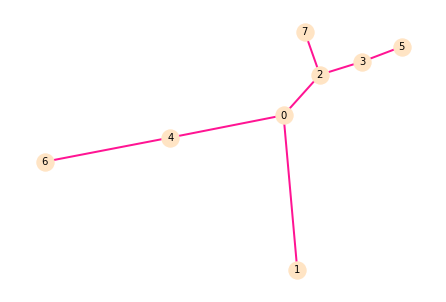

My traversal is df
Neighbors of node 0: ['1', '4', '2']
Neighbors of node 1: ['0']
Neighbors of node 2: ['7', '0', '3']
Neighbors of node 3: ['5', '2']
Neighbors of node 4: ['6', '0']
Neighbors of node 5: ['3']
Neighbors of node 6: ['4']
Neighbors of node 7: ['2']
{'6': '4', '0': '4', '1': '0', '2': '0', '7': '2', '3': '2', '5': '3'}
here come the alignment pairs DAMMIT: 

{'6': '4', '0': '4', '1': '0', '2': '0', '7': '2', '3': '2', '5': '3'}
here comes the index_dict DAMMIT: 

{'4': '0', '6': '1', '0': '2', '1': '3', '2': '4', '7': '5', '3': '6', '5': '7'}
starting point: 
4
nr of seqs:
8
new seqs before loop
[Seq('atggatttatctgctgttcgcgttgaagaagtacaaaatgtcattaatgctatg...tga'), None, None, None, None, None, None, None]
idx:4, i=0
idx:6, i=1
idx:0, i=2
idx:1, i=3
idx:2, i=4
idx:7, i=5
idx:3, i=6
idx:5, i=7
new s1-index:
2
seqs new:
[Seq('gcgaaatgtaacacggtagaggtgatcggggtgcgttatacgtgcgtggtgacc...gat'), Seq('gtaccttgatttcgtattctgagaggctgctgcttagcggtagccccttggttt...tct'), Seq('atggatttatct

In [34]:
score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5
total_cost_new, M, matrix_for_MST, visiting_order,graph=new_sp_approxi_combi(brca_seqs_work_please,score_matrix,gap_cost,"spring",traversal_here="df")
print("total cost following: ")
print(total_cost_new)
print(M)
#print(graph)
#print(matrix_for_MST)
#print(my_traversal_simply(graph,'1'))